# Rainband Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the rainband of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.

We start by evaluating each tropical cyclone (TC) individually, and then look at basin-level threshold trends and distributions. Below are the different basins:
* ATL - Atlantic Ocean basin
* CPAC - Central Pacific basin
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The rainband dataset is created in the `rainband_data.ipynb` notebook as `rainband_shear_timebin_joined.csv`. This file can be found in the `data_pipeline/data/` directory of the repository.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches
from lightning_threshold_functions import *

In [2]:
rainband_data = pd.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_data = pl.from_pandas(rainband_data)

In [3]:
rainband_data.head()

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_k ┆ 24_hour_p ┆ TC_Catego ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ nots_diff ┆ ressure_d ┆ ry        ┆ ication_ │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ iff       ┆ ---       ┆ Category │
│           ┆ str       ┆ str       ┆ i64       ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ 25.0      ┆ -7.0      ┆ Unidentif ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [4]:
# import data from csv file
rainband_data = rainband_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"), # Parse basin from storm code
    pl.col("lightning_count").log1p().alias("log_lightning_count"), # Log transform the counts
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_data = rainband_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_data = rainband_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_data.head()

shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_p ┆ Current_C ┆ Intensifi ┆ log_ligh │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ressure_d ┆ ategory   ┆ cation_Ca ┆ tning_co │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ iff       ┆ ---       ┆ tegory_5  ┆ unt      │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ str       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 4.330733 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 2.484907 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 3.295837 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ -7.0      ┆ 0         ┆ Intensify ┆ 1.098612 │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [5]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_data = rainband_data.with_columns(
    rainband_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_data.head()

shape: (5, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ Current_C ┆ Intensifi ┆ log_light ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ategory   ┆ cation_Ca ┆ ning_coun ┆ ication_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ tegory_5  ┆ t         ┆ Category │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ str       ┆ ---       ┆ ---       ┆ _3       │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 75        ┆ … ┆ 0         ┆ Intensify ┆ 4.330733  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 11        ┆ … ┆ 0         ┆ Intensify ┆ 2.484907  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 26        ┆ … ┆ 0         ┆ Intensify ┆ 3.295837  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 2         ┆ … ┆ 0         ┆ Intensify ┆ 1.098612  ┆ Intensif │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 15:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [6]:
# Create dataframe for filtering later
storm_names = rainband_data[["storm_code", "storm_name"]].unique()

-------------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We do not group by shear quadrant when evaluating burst thresholds, but we will look at the shear quadrant associated with identified bursts. 

We start by filtering out data associated with wind speeds less than 40 knots.

In [7]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity (0 lightning count).

In [8]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0)
tc_summary_w_0.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1          121           68        3.465736        4.158883   
1  ATL_10_11          779          779        0.000000        0.000000   
2  ATL_10_12          230          230        0.000000        0.000000   
3  ATL_10_13          175          175        0.000000        0.000000   
4  ATL_10_14           51           51        0.000000        0.000000   
5  ATL_10_17          174          174        0.000000        0.000000   
6  ATL_10_18          200          153        3.465736        4.158883   
7  ATL_10_19            0            0        8.816516       10.534168   
8  ATL_10_20           40           40        0.000000        0.000000   
9  ATL_10_21           69           21        5.493061        6.591674   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        5.914525        7.393156            31   
1          227          130        2.772589        3.465736           140   
2          230          230        0.000000        0.000000            77   
3           25            3        4.217775        5.272218            27   
4           51           51        0.000000        0.000000            31   
5          174          174        0.000000        0.000000            41   
6            0            0        7.533895        9.417369            24   
7            0            0        6.883849        8.604811             7   
8           29           27        1.386294        1.732868             9   
9           58            4        5.780744        7.225929            71   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         5.000153         6.718335         672      18.01   
1            22         3.344007         4.610436        2064      37.74   
2            39         1.465070         2.084402        1432      16.06   
3             0         4.083537         5.574662         384      45.57   
4            24         1.299440         1.871215         576       8.85   
5            17         1.769666         2.488341         720      24.17   
6             0         6.215064         8.400447         720      27.78   
7             0         5.441545         7.158070         524       0.00   
8             3         3.122291         4.356587         144      27.78   
9             3         5.412132         7.290620        1440       4.79   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      10.12       0.00       0.00        4.61        0.00  
1      37.74      11.00       6.30        6.78        1.07  
2      16.06      16.06      16.06        5.38        2.72  
3      45.57       6.51       0.78        7.03        0.00  
4       8.85       8.85       8.85        5.38        4.17  
5      24.17      24.17      24.17        5.69        2.36  
6      21.25       0.00       0.00        3.33        0.00  
7       0.00       0.00       0.00        1.34        0.00  
8      27.78      20.14      18.75        6.25        2.08  
9       1.46       4.03       0.28        4.93        0.21

In [9]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     0.668586
mad2_threshold     0.801124
iqr1_threshold     1.869827
iqr2_threshold     2.336712
logn1_threshold    2.879543
logn2_threshold    3.983364
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.684268
logn2_threshold    3.770915
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

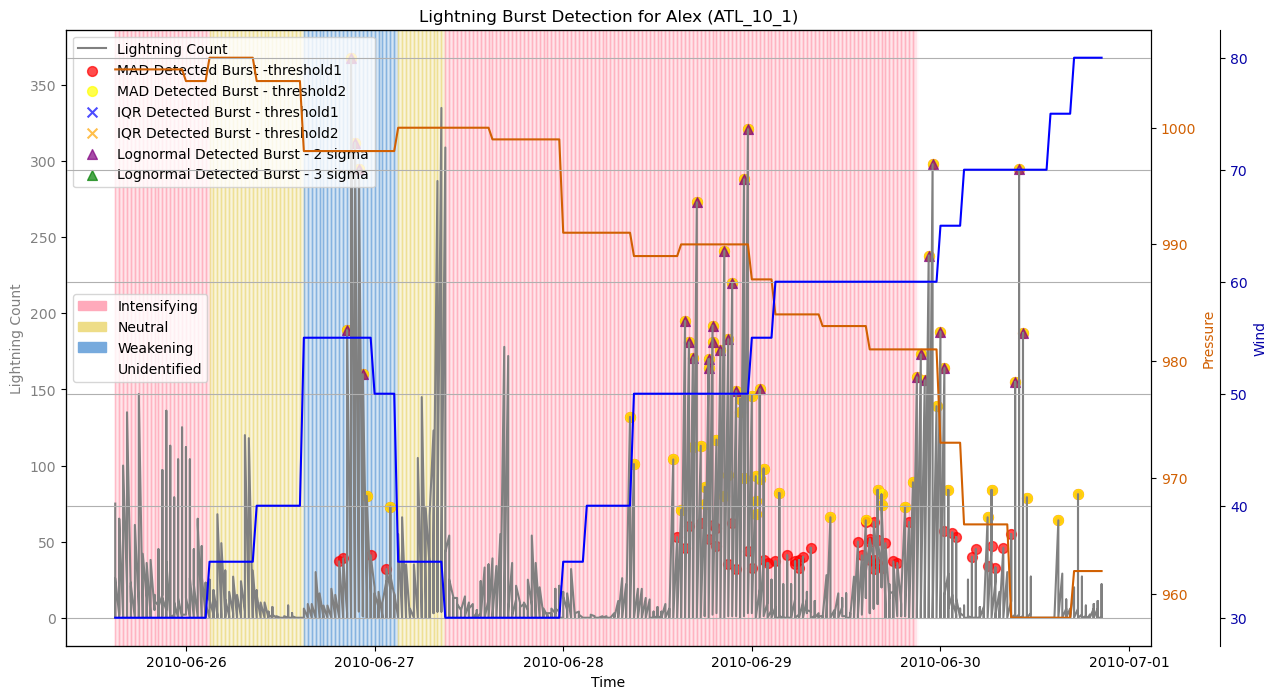

<Figure size 1000x500 with 0 Axes>

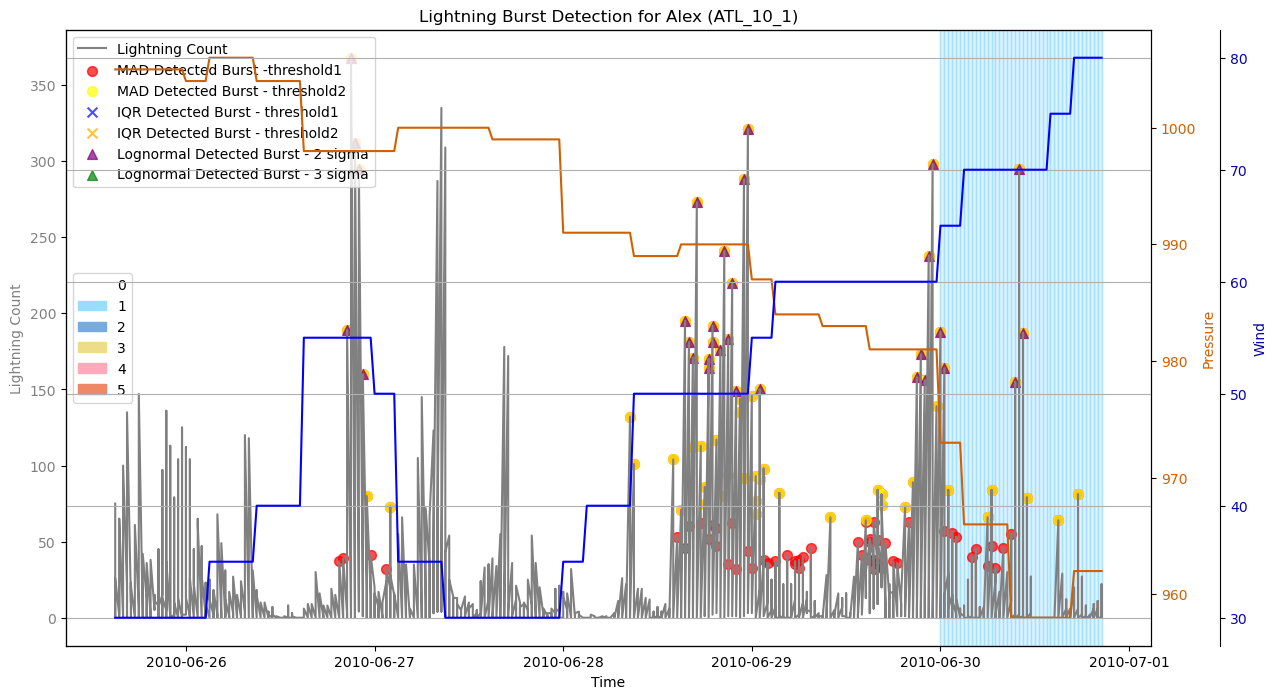

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1          121           68        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        5.914525        7.393156            31   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         5.000153         6.718335         672      18.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      10.12        0.0        0.0        4.61         0.0

In [10]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'

plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

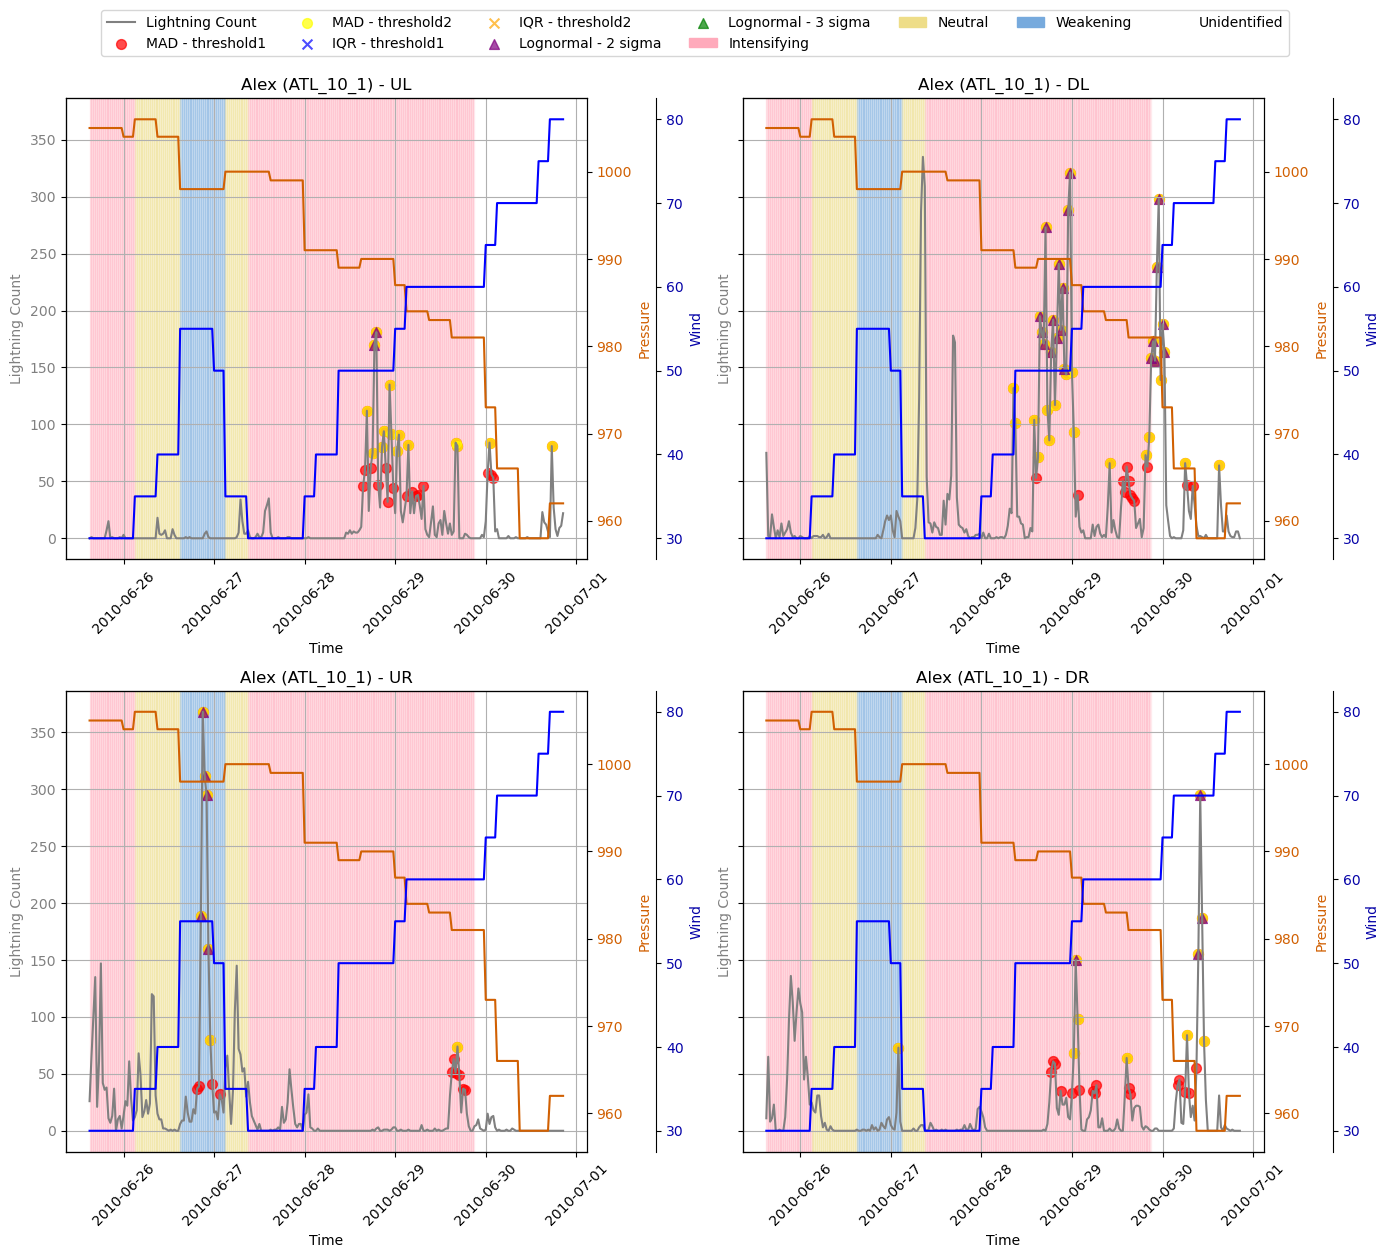

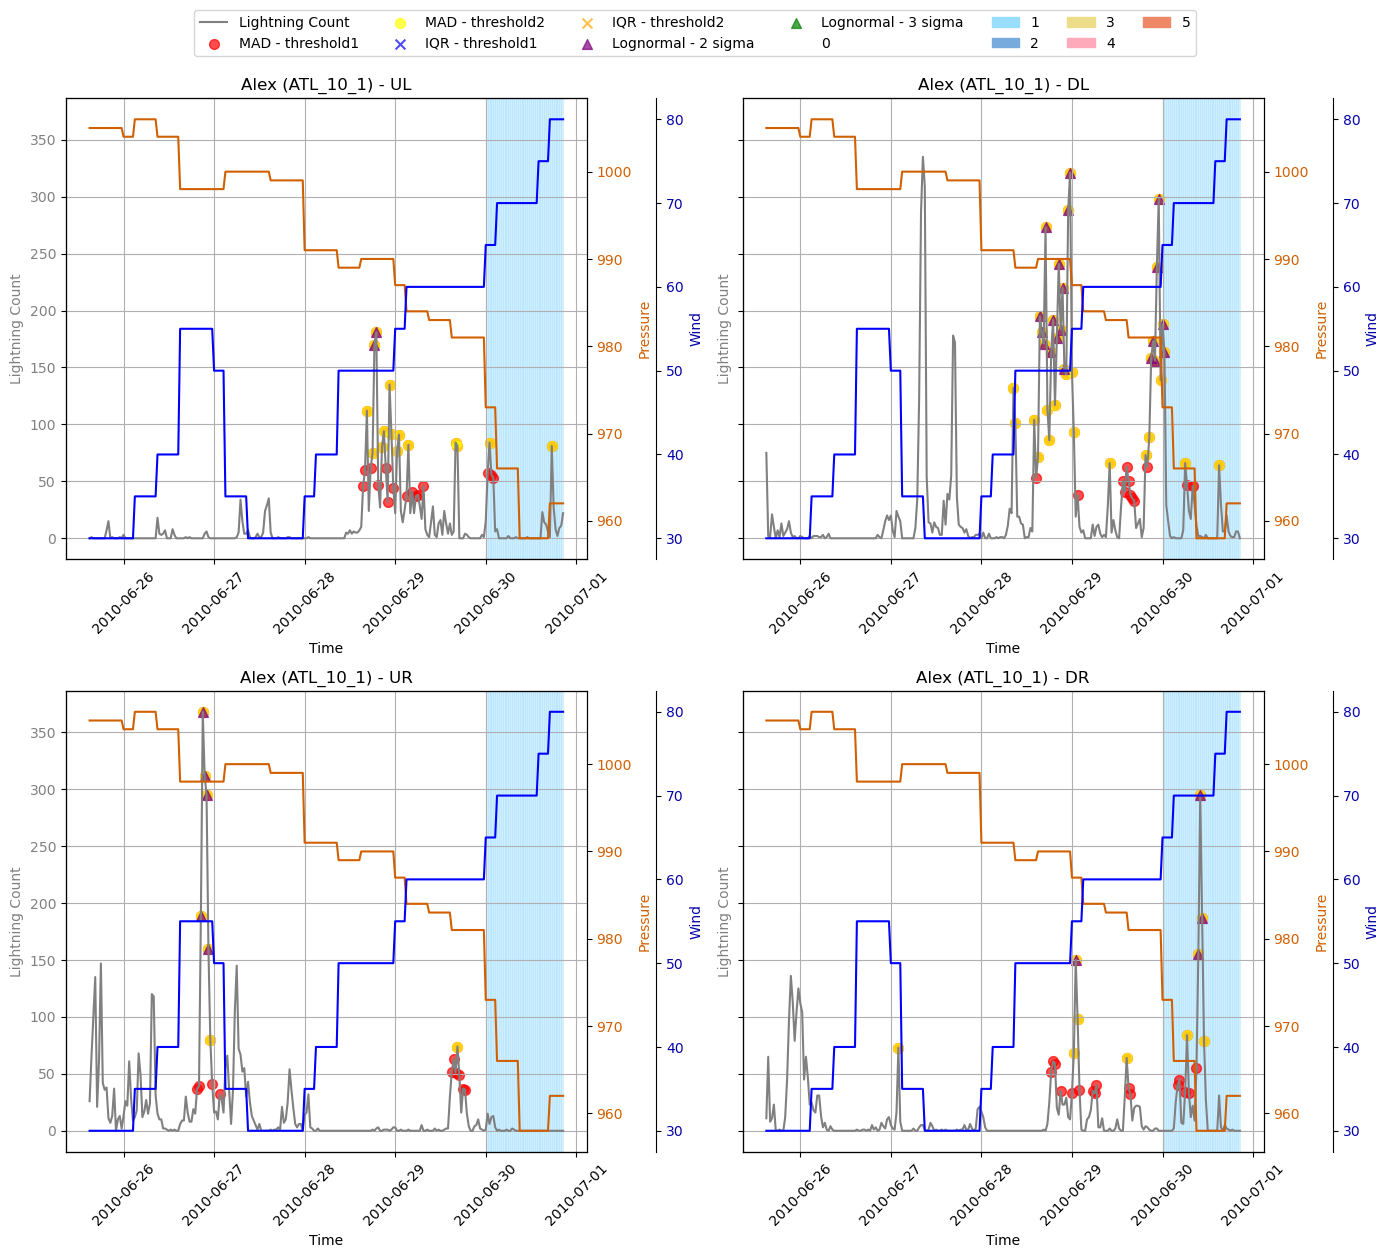

In [11]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")

We then apply the threshold evaluation to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [12]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0  EPAC_17_16        Max            0            0        7.164199   
1  SHEM_11_15     Carlos           16            6        4.158883   
2   EPAC_12_3   Carlotta            0            0        8.940374   
3   ATL_10_18      Paula            0            0        9.399032   
4  SHEM_16_15   Emeraude           18           10        2.720473   
5   SHEM_17_5      Dineo            2            0        5.440945   
6    ATL_12_5    Ernesto            0            0        7.279569   
7  WPAC_10_11    Meranti            1            0        5.180951   
8   WPAC_14_6      Tapah            8            5        2.720473   
9  WPAC_16_21      Chaba            0            0        5.274601   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        7.888788            0            0        6.996854        8.005202   
1        4.852030           16            6        4.102643        4.955017   
2       10.474743            0            0        7.327123        8.812331   
3       10.839394            0            0        8.014430        9.531560   
4        3.125938            3            0        3.701302        4.453341   
5        6.251876            3            0        5.241061        6.204752   
6        8.458224            0            0        6.112575        7.294146   
7        6.028249            3            1        4.342375        5.135336   
8        3.125938            5            2        2.890372        3.439678   
9        6.190892            4            0        4.584967        5.557923   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         6.906256         8.451879          16       0.00   
1  ...             0         4.980841         6.496384          97      16.49   
2  ...             0         6.231871         7.901580         232       0.00   
3  ...             0         7.126656         8.956440         383       0.00   
4  ...             0         3.393722         4.320259         112      16.07   
5  ...             0         4.941328         6.206732         222       0.90   
6  ...             0         5.507069         6.952000         863       0.00   
7  ...             1         4.124368         5.173021         114       0.88   
8  ...             1         3.126075         3.950825          77      10.39   
9  ...             0         4.141313         5.274791         173       0.00   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0       0.00       0.00       0.00        0.00        0.00  
1       6.19      16.49       6.19        6.19        0.00  
2       0.00       0.00       0.00        0.00        0.00  
3       0.00       0.00       0.00        0.26        0.00  
4       8.93       2.68       0.00        4.46        0.00  
5       0.00       1.35       0.00        3.15        0.00  
6       0.00       0.00       0.00        1.39        0.00  
7       0.00       2.63       0.88        2.63        0.88  
8       6.49       6.49       2.60        6.49        1.30  
9       0.00       2.31       0.00        4.62        0.00  

[10 rows x 21 columns]

<Figure size 1000x500 with 0 Axes>

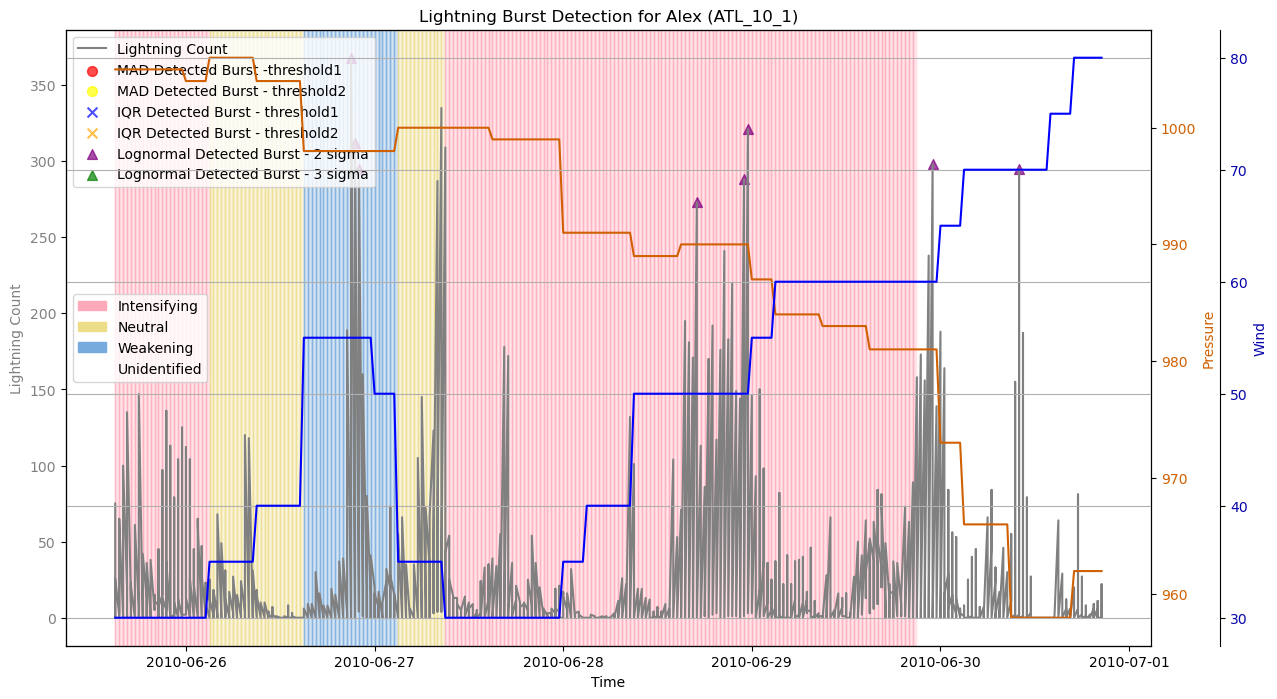

<Figure size 1000x500 with 0 Axes>

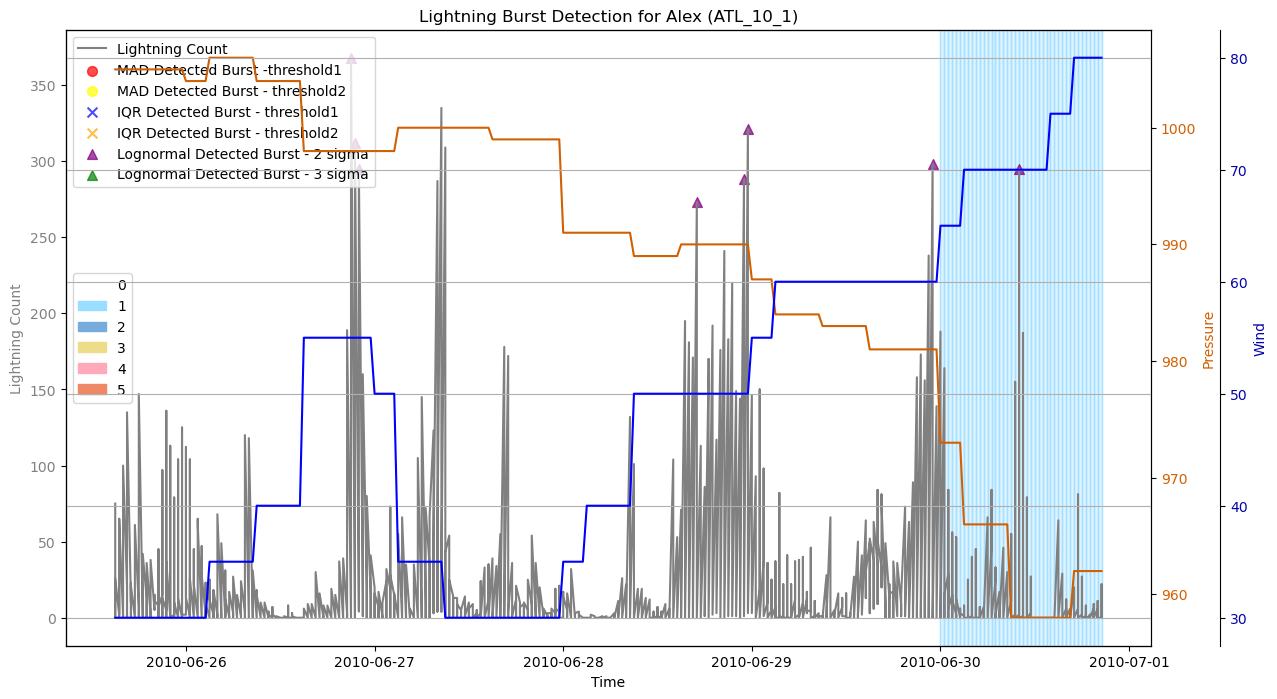

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
288   ATL_10_1       Alex            0            0        7.397394   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
288        8.586978            0            0         6.04085        7.204489   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
288  ...             0          5.54689         6.969608         389   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
288        0.0        0.0        0.0        0.0        2.06         0.0  

[1 rows x 21 columns]

In [13]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

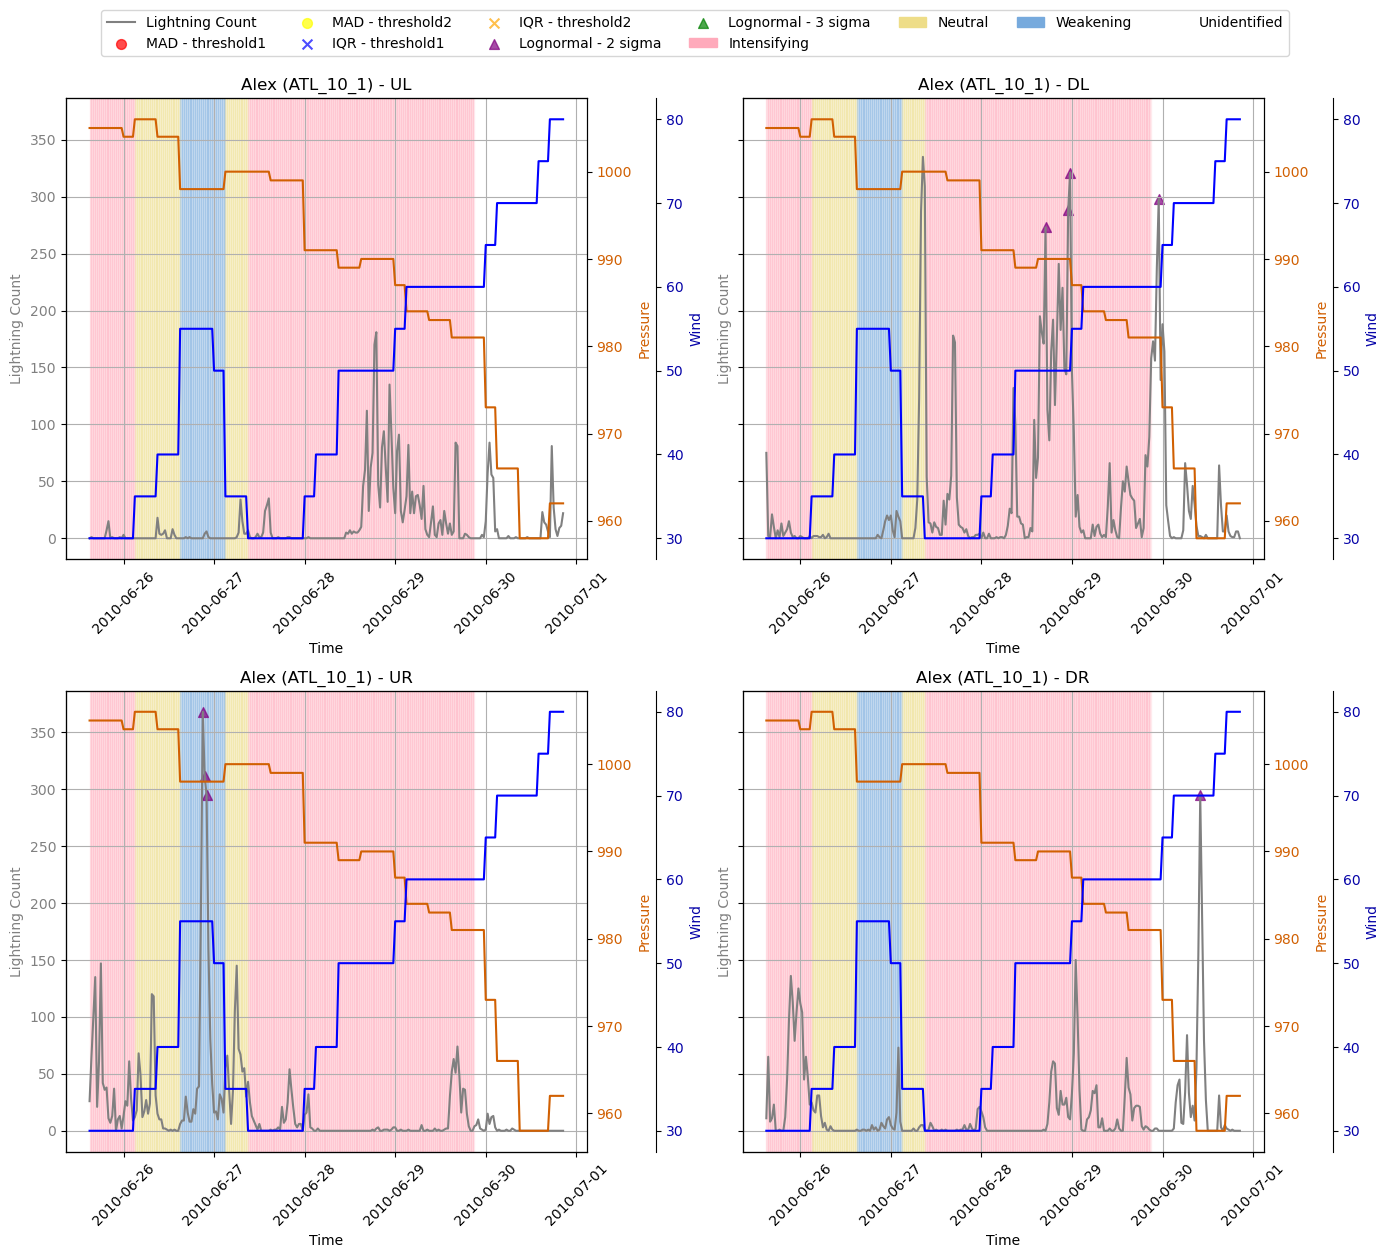

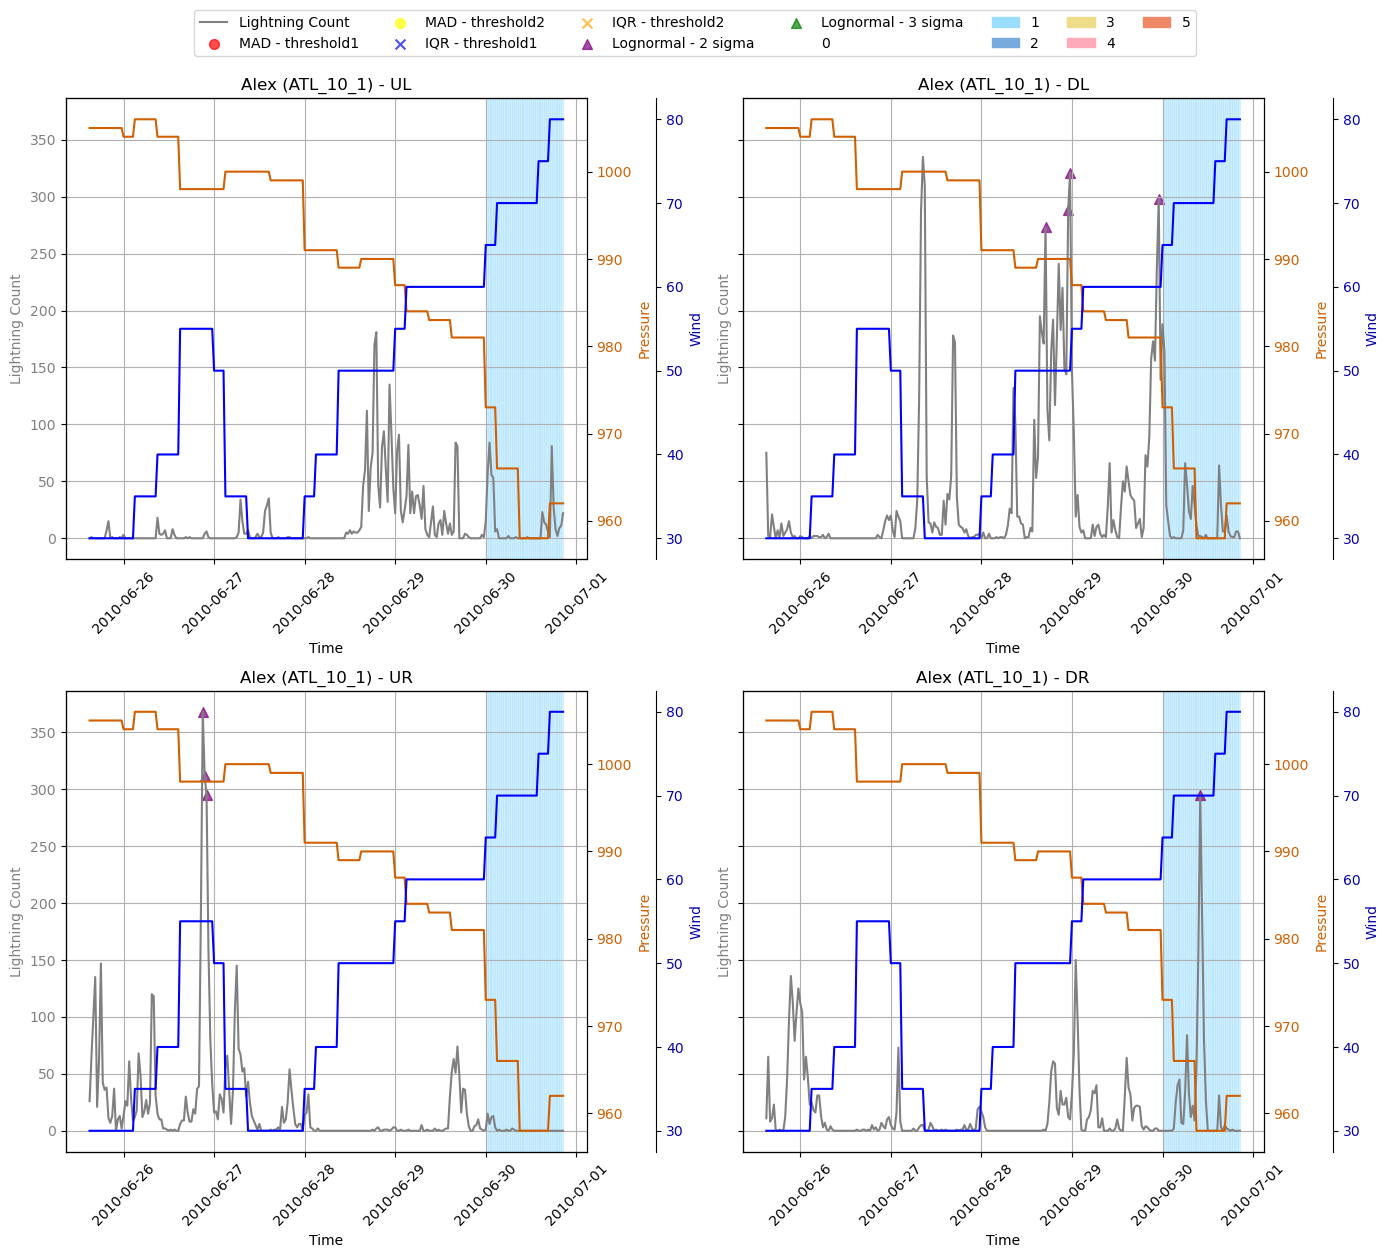

In [14]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

In [15]:
rainband_data_pd = rainband_data.to_pandas()
# marker - what is this doing?
filtered_df = rainband_data_pd[rainband_data_pd['storm_code'].str.contains('^EPAC')]
filtered_df

time_bin shear_quad storm_code  lightning_count  year  \
78400  2010-06-18 15:00:00         DL  EPAC_10_4                0  2010   
78401  2010-06-18 15:00:00         DR  EPAC_10_4                0  2010   
78402  2010-06-18 15:00:00         UL  EPAC_10_4                3  2010   
78403  2010-06-18 15:00:00         UR  EPAC_10_4                0  2010   
78404  2010-06-18 15:30:00         DL  EPAC_10_4                0  2010   
...                    ...        ...        ...              ...   ...   
139647 2017-07-29 01:00:00         UR  EPAC_17_9                0  2017   
139648 2017-07-29 01:30:00         DL  EPAC_17_9                0  2017   
139649 2017-07-29 01:30:00         DR  EPAC_17_9                0  2017   
139650 2017-07-29 01:30:00         UL  EPAC_17_9                1  2017   
139651 2017-07-29 01:30:00         UR  EPAC_17_9                0  2017   

        month  day  hour  minute   lat  ...  knots  storm_name  category  \
78400       6   18    15       0  13.2  ...     25       Celia         5   
78401       6   18    15       0  13.2  ...     25       Celia         5   
78402       6   18    15       0  13.2  ...     25       Celia         5   
78403       6   18    15       0  13.2  ...     25       Celia         5   
78404       6   18    15      30  13.2  ...     25       Celia         5   
...       ...  ...   ...     ...   ...  ...    ...         ...       ...   
139647      7   29     1       0  20.0  ...     55      Hilary         2   
139648      7   29     1      30  20.0  ...     55      Hilary         2   
139649      7   29     1      30  20.0  ...     55      Hilary         2   
139650      7   29     1      30  20.0  ...     55      Hilary         2   
139651      7   29     1      30  20.0  ...     55      Hilary         2   

       basin  24_hour_knots_diff 24_hour_pressure_diff  Current_Category  \
78400   EPAC                15.0                  -8.0                 0   
78401   EPAC                15.0                  -8.0                 0   
78402   EPAC                15.0                  -8.0                 0   
78403   EPAC                15.0                  -8.0                 0   
78404   EPAC                15.0                  -8.0                 0   
...      ...                 ...                   ...               ...   
139647  EPAC                 NaN                   NaN                 0   
139648  EPAC                 NaN                   NaN                 0   
139649  EPAC                 NaN                   NaN                 0   
139650  EPAC                 NaN                   NaN                 0   
139651  EPAC                 NaN                   NaN                 0   

        Intensification_Category_5 log_lightning_count  \
78400                 Intensifying            0.000000   
78401                 Intensifying            0.000000   
78402                 Intensifying            1.386294   
78403                 Intensifying            0.000000   
78404                 Intensifying            0.000000   
...                            ...                 ...   
139647                Unidentified            0.000000   
139648                Unidentified            0.000000   
139649                Unidentified            0.000000   
139650                Unidentified            0.693147   
139651                Unidentified            0.000000   

       Intensification_Category_3  
78400                Intensifying  
78401                Intensifying  
78402                Intensifying  
78403                Intensifying  
78404                Intensifying  
...                           ...  
139647               Unidentified  
139648               Unidentified  
139649               Unidentified  
139650               Unidentified  
139651               Unidentified  

[61252 rows x 22 columns]

<Figure size 1000x500 with 0 Axes>

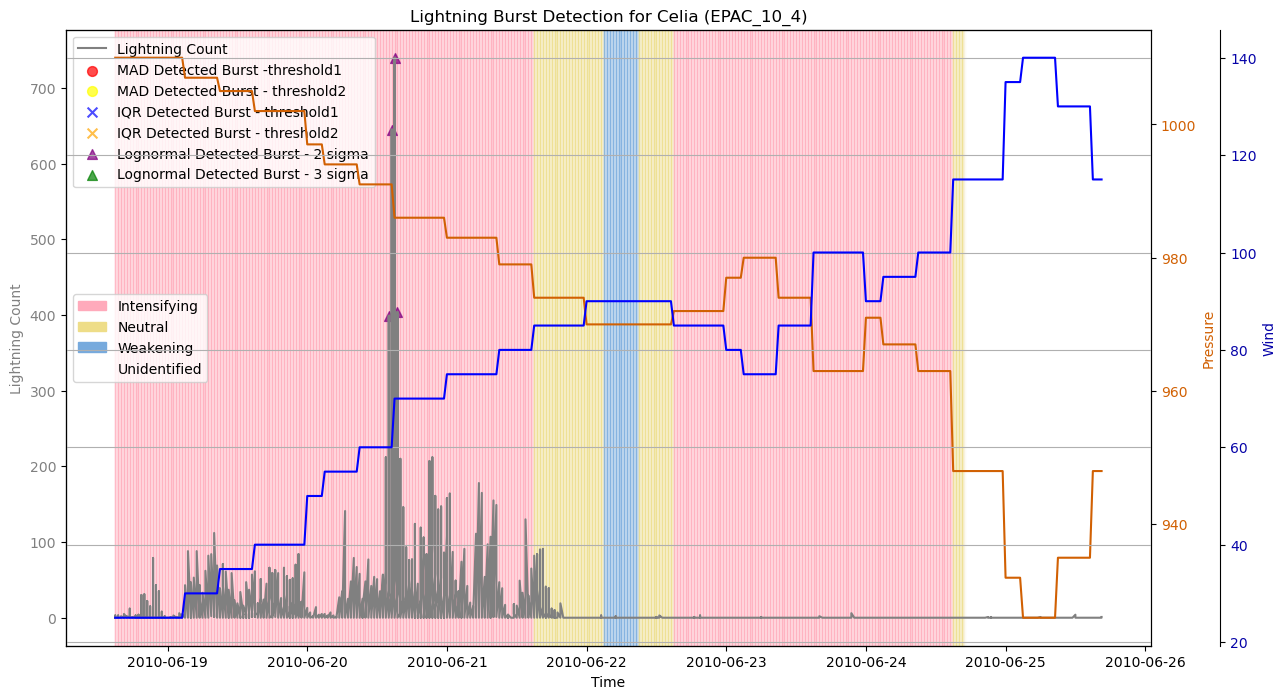

<Figure size 1000x500 with 0 Axes>

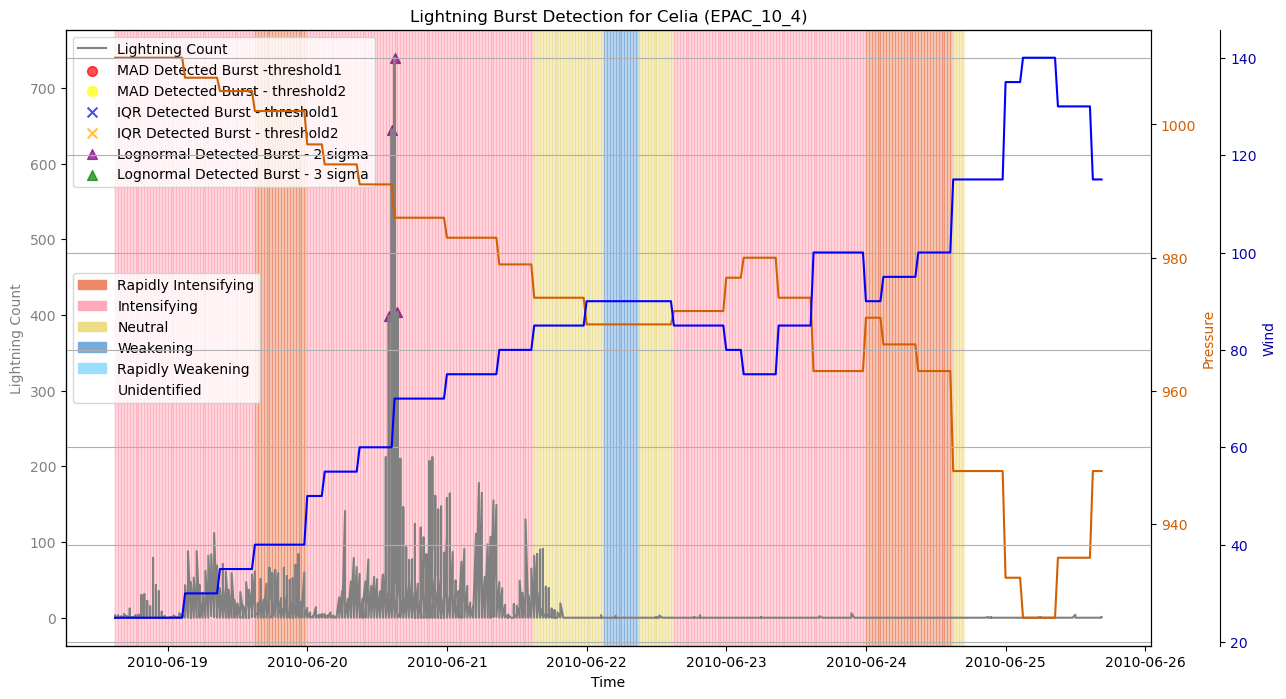

<Figure size 1000x500 with 0 Axes>

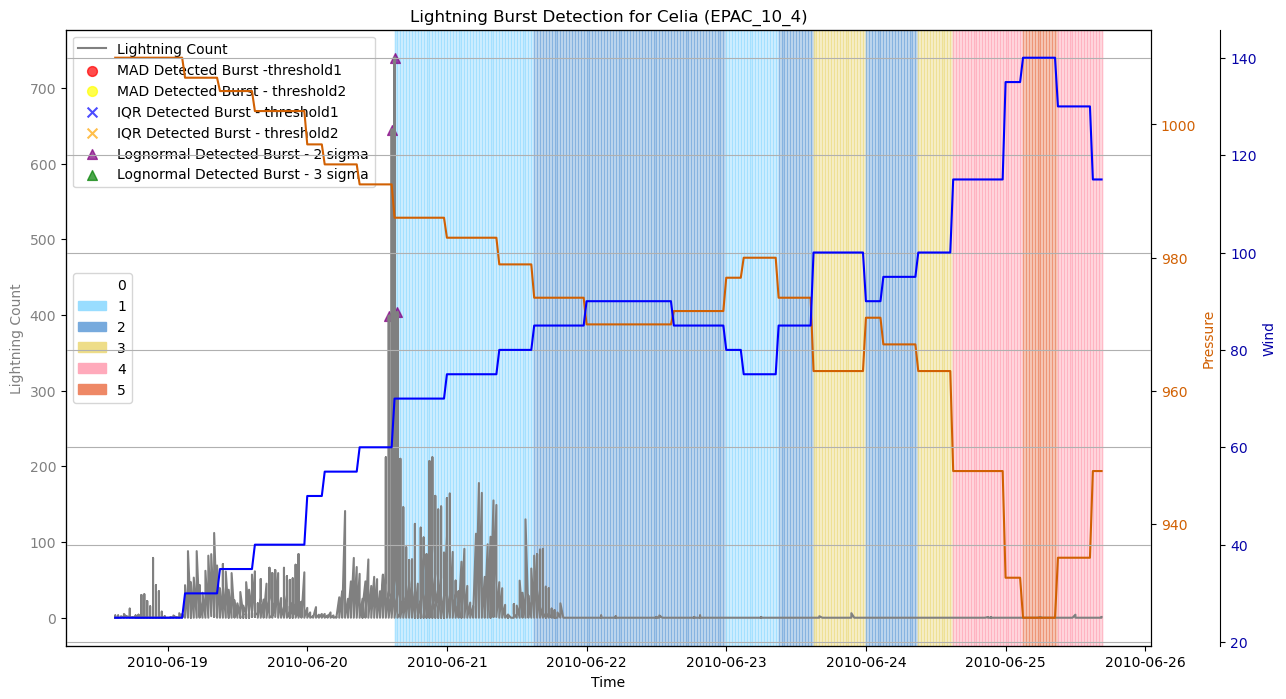

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
96  EPAC_10_4      Celia            0            0        8.020353   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
96        9.241567            0            0        6.768781        8.114402   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
96  ...             0          5.89286         7.389035         229   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
96        0.0        0.0        0.0        0.0        1.75         0.0  

[1 rows x 21 columns]

In [16]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

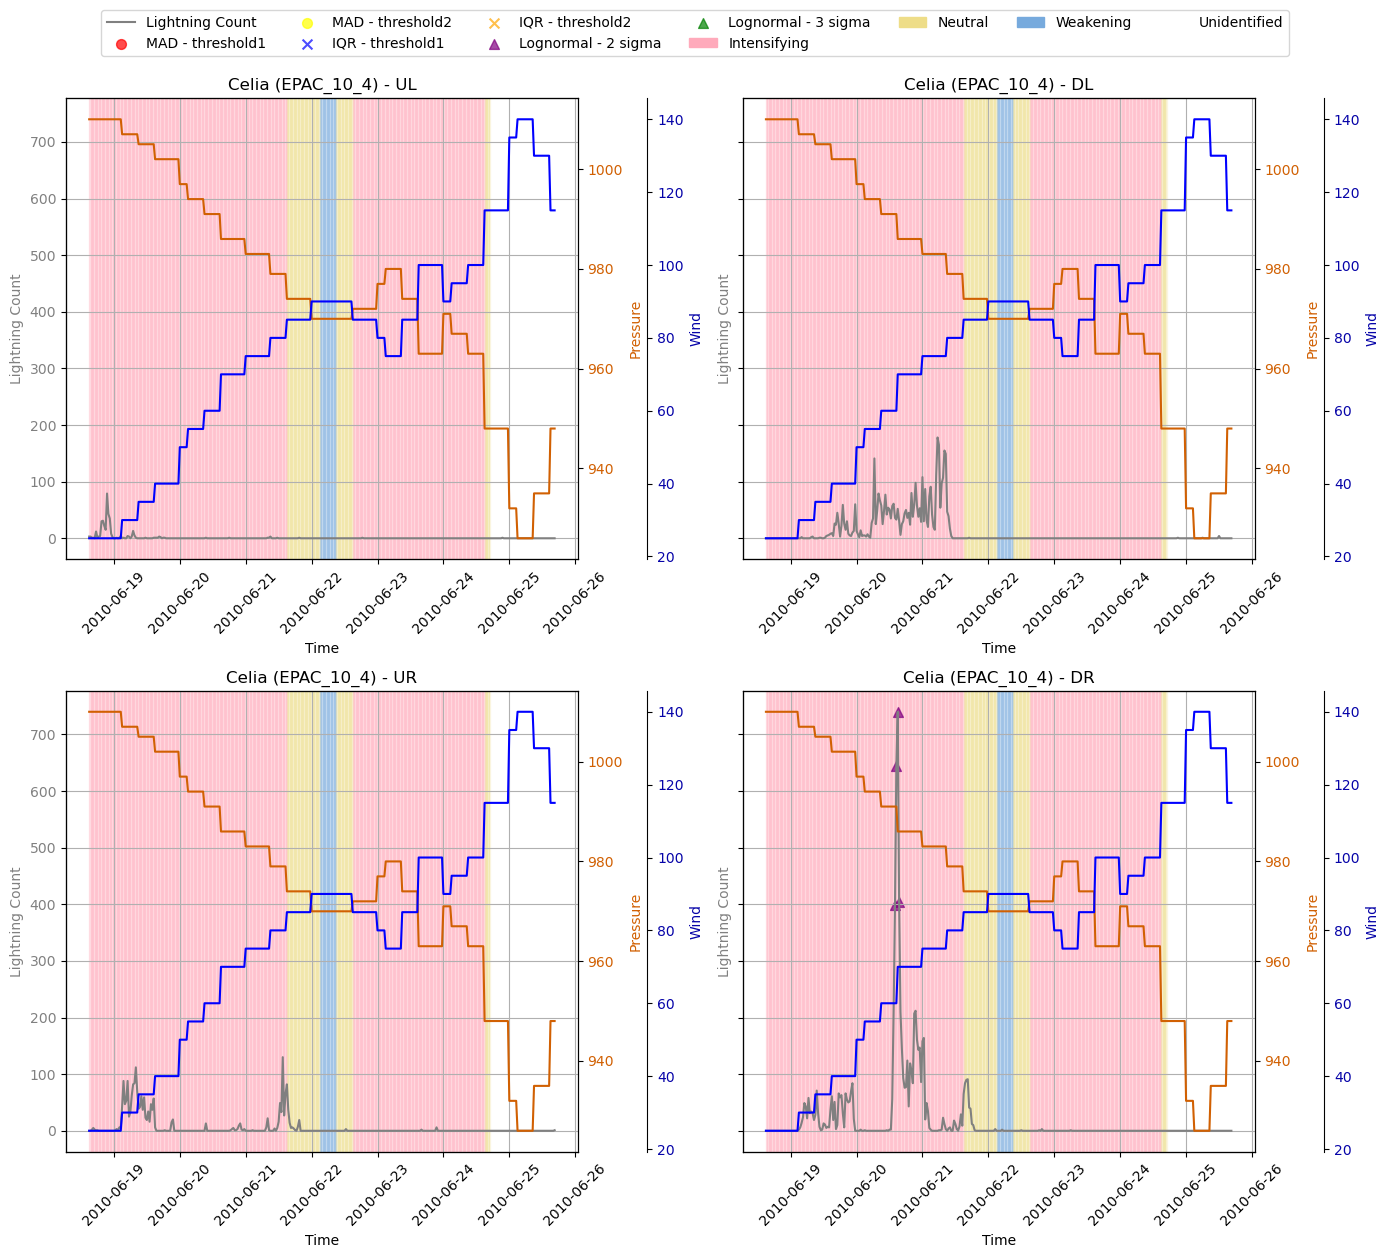

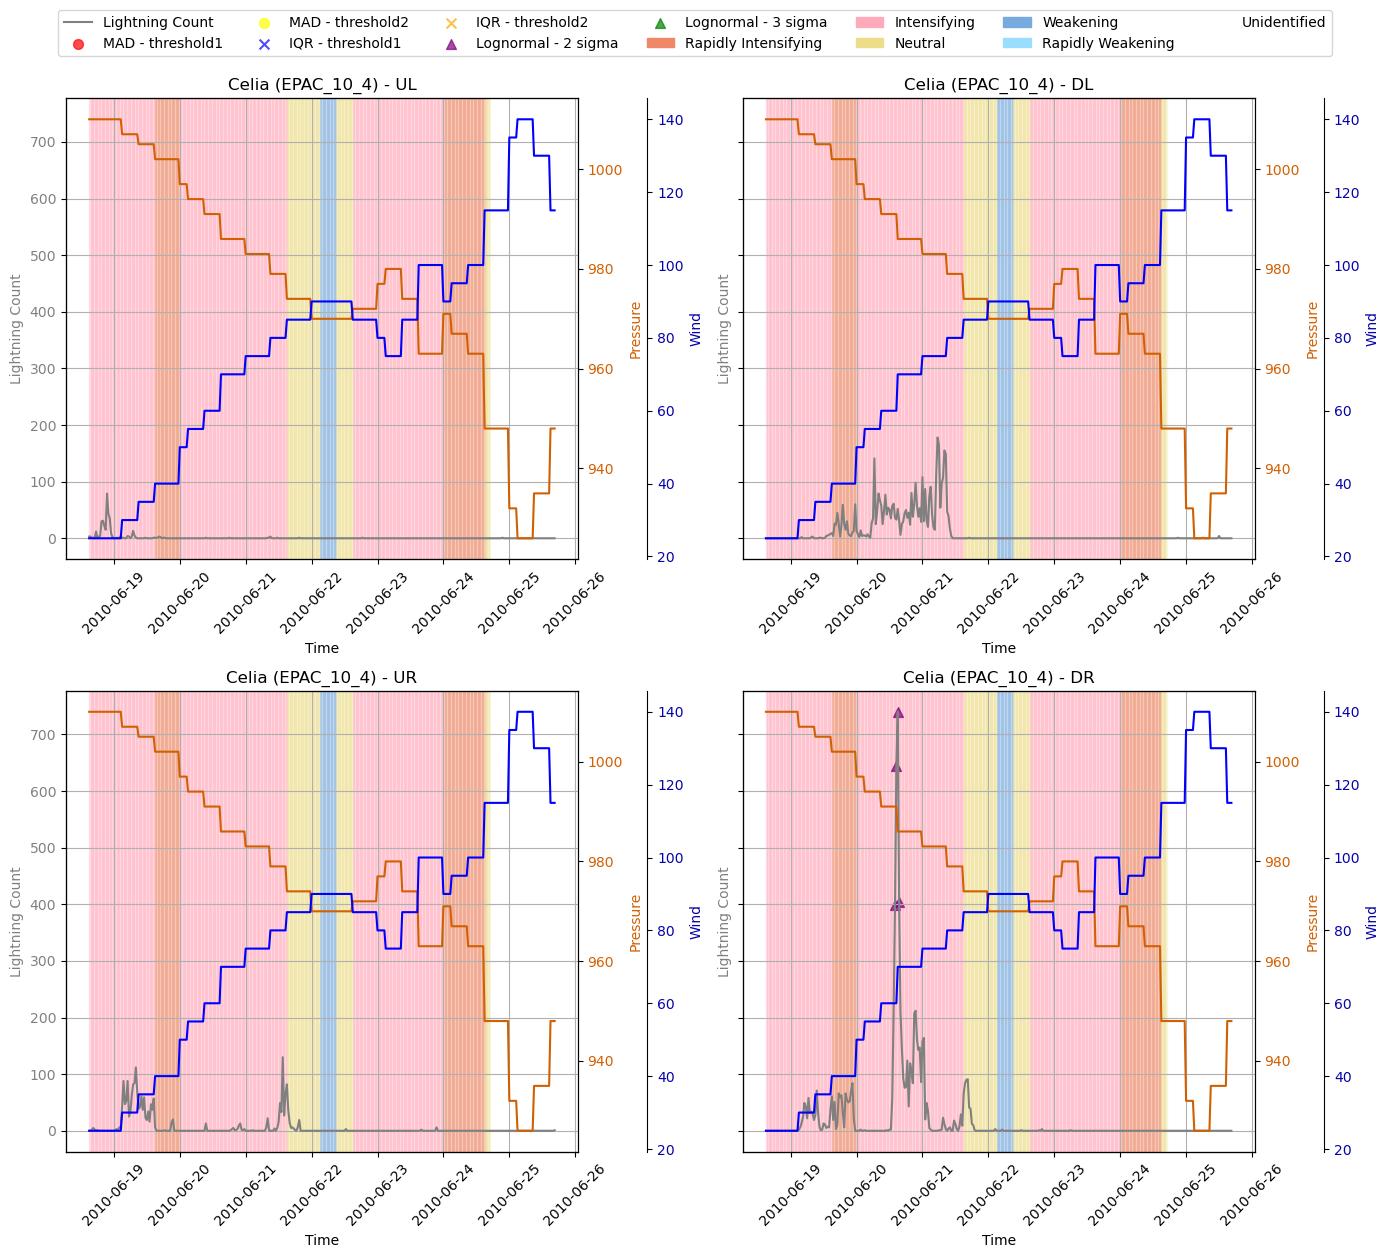

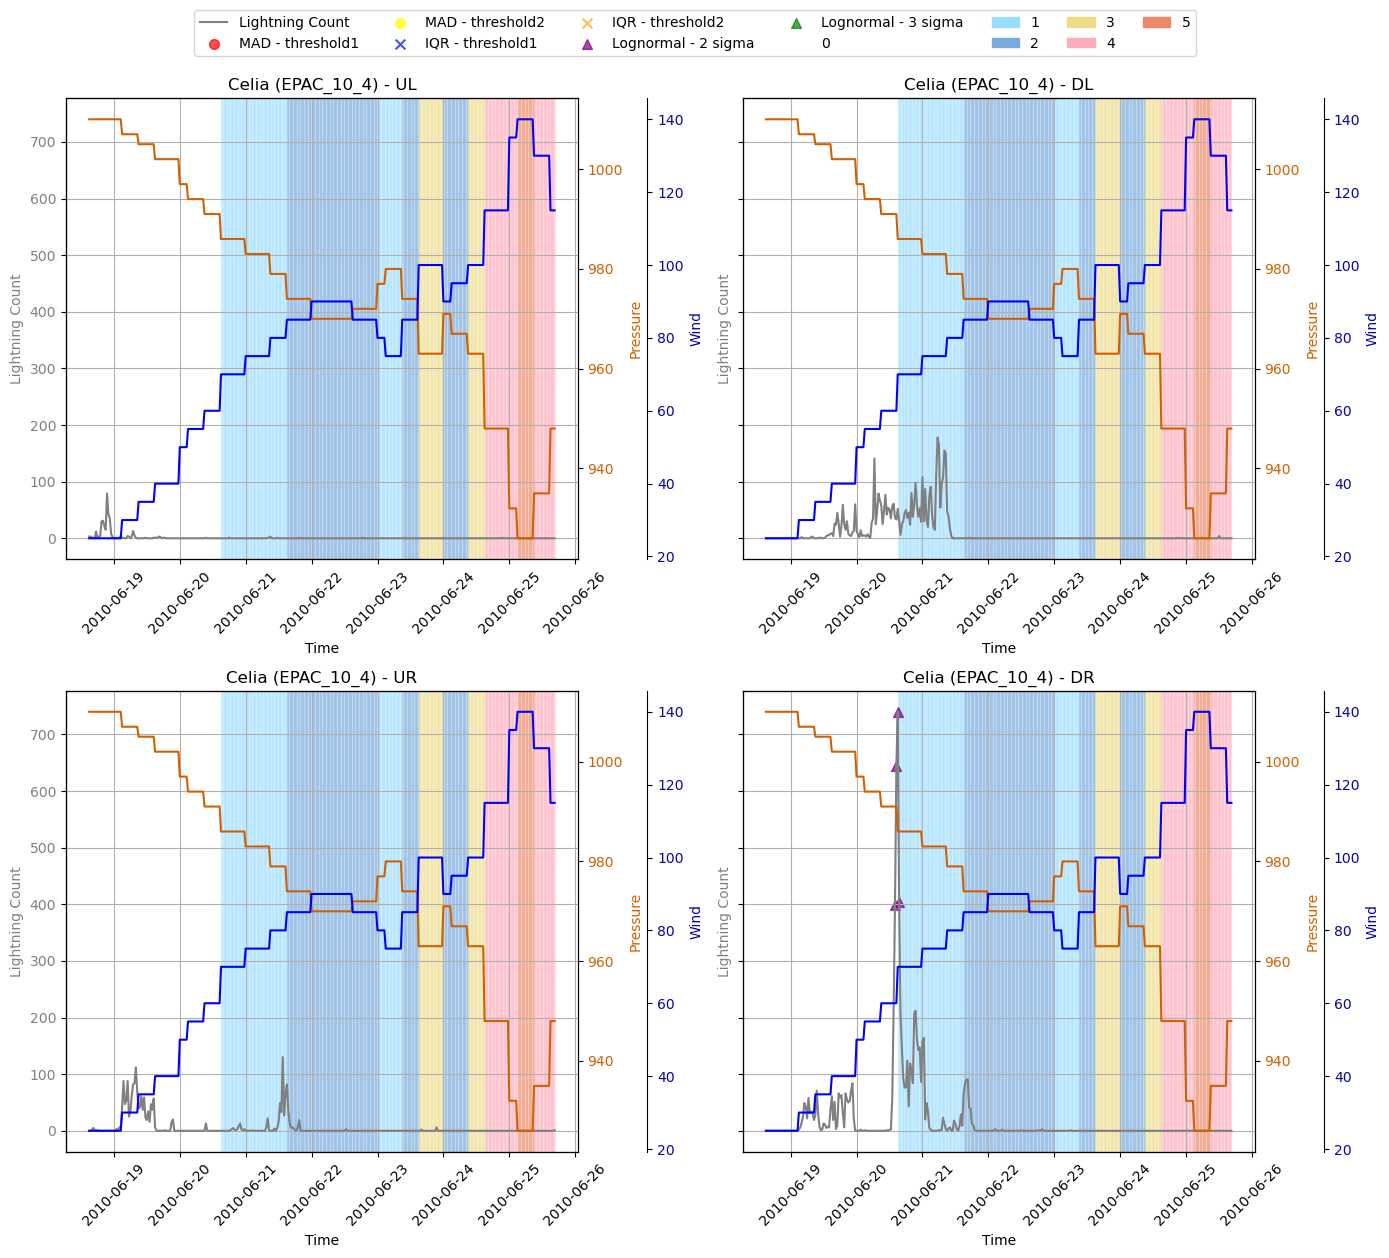

In [ ]:
# EPAC_10_4 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

<Figure size 1000x500 with 0 Axes>

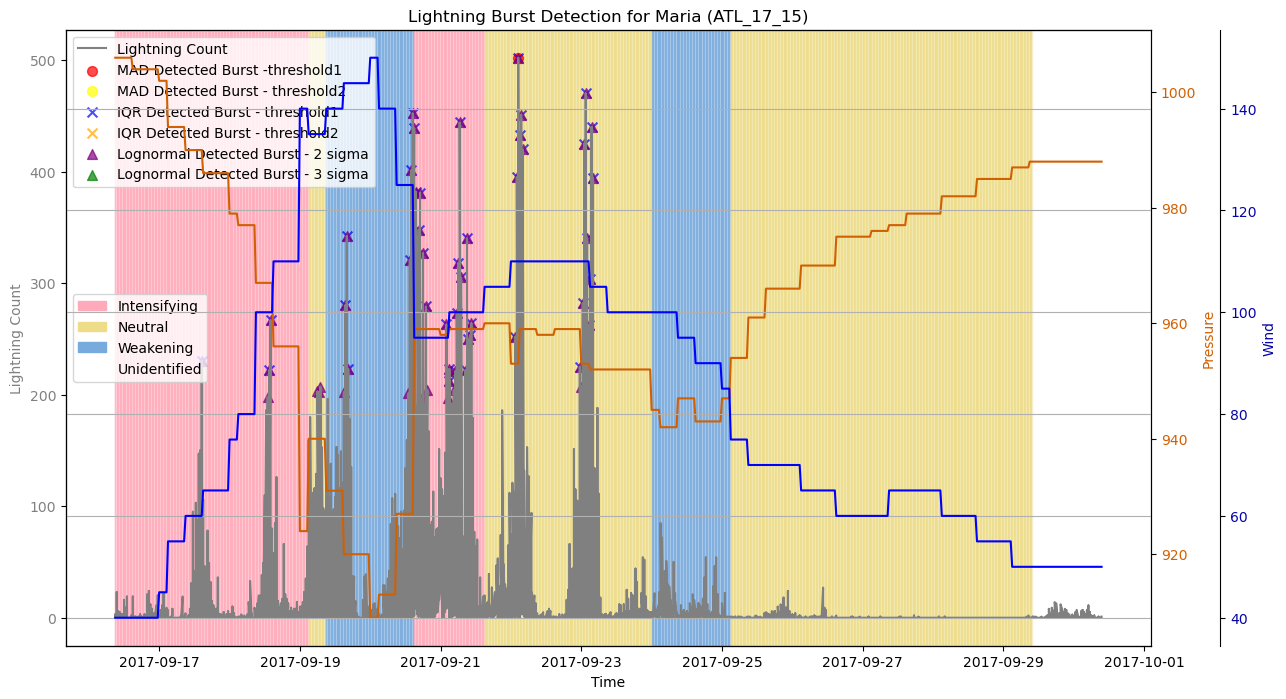

<Figure size 1000x500 with 0 Axes>

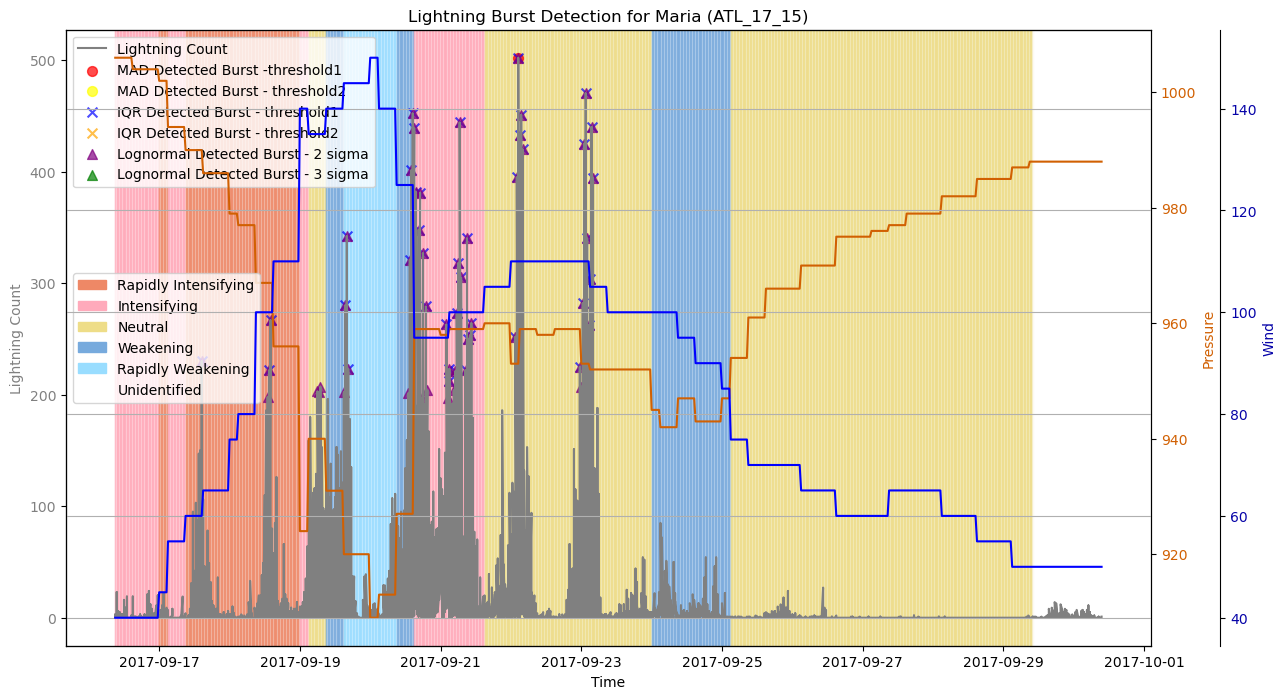

<Figure size 1000x500 with 0 Axes>

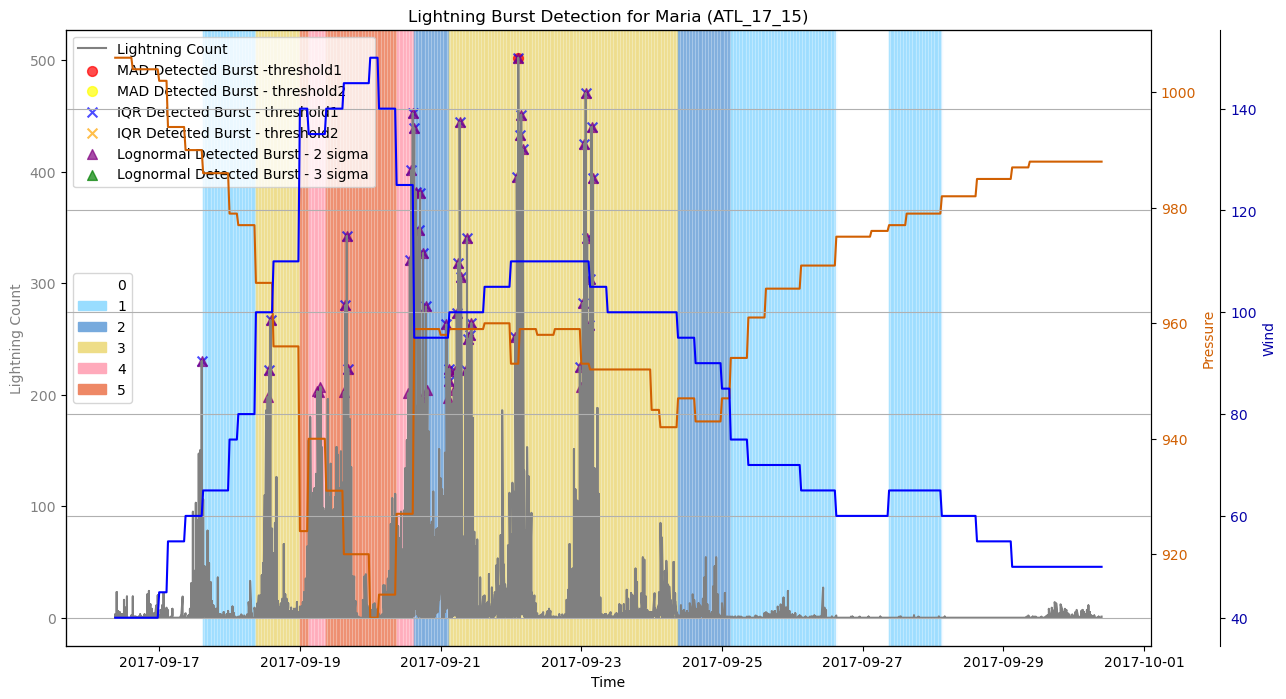

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
24  ATL_17_15      Maria            1            0        6.186209   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
24        7.284821           43            0        5.339139        6.399271   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
24  ...             0         5.283362         6.780531        1045   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
24        0.1        0.0       4.11        0.0        5.17         0.0  

[1 rows x 21 columns]

In [18]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

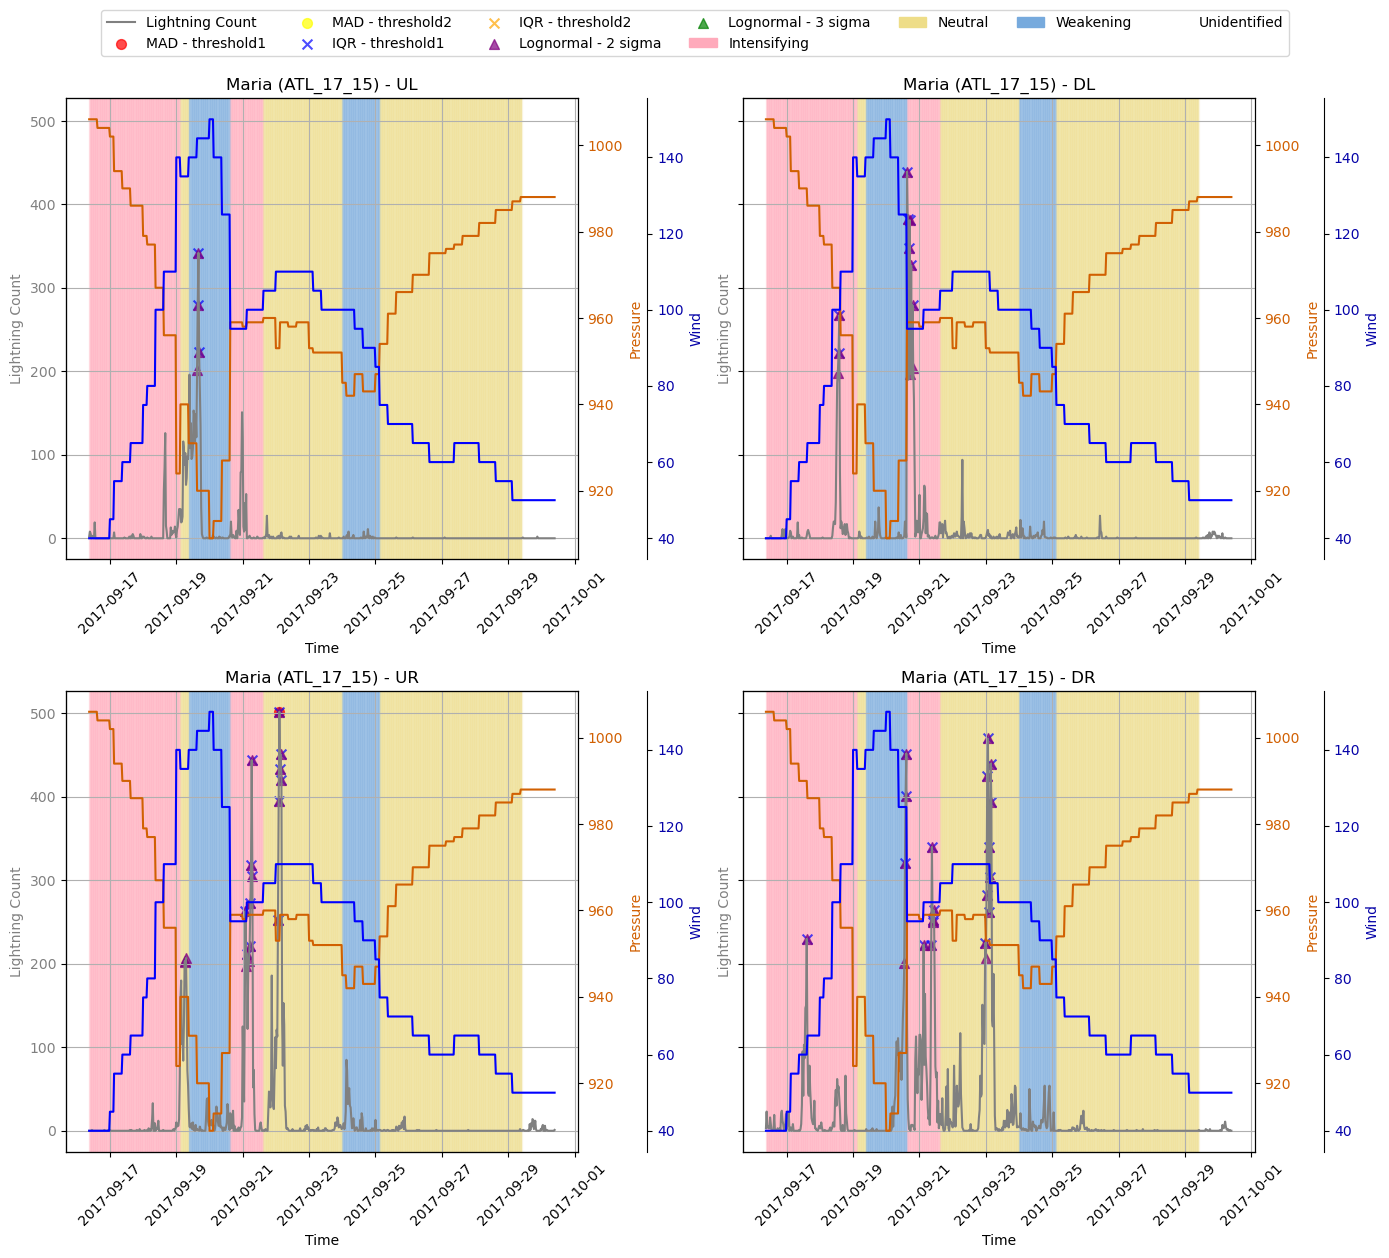

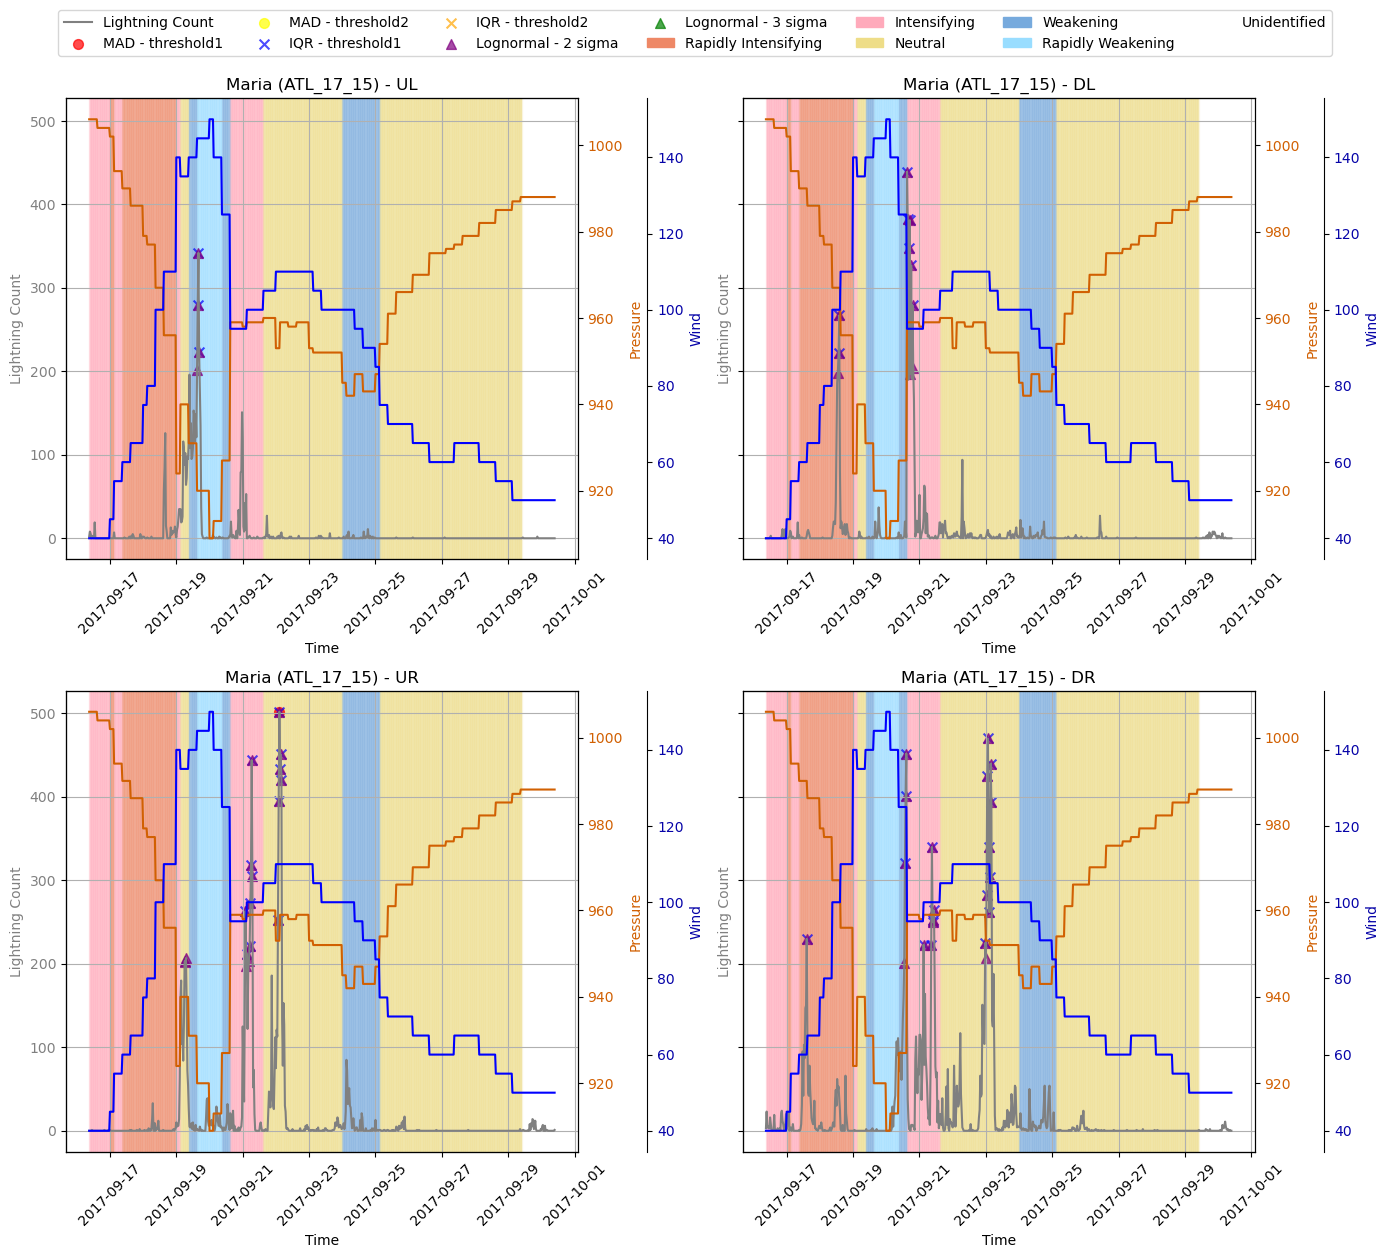

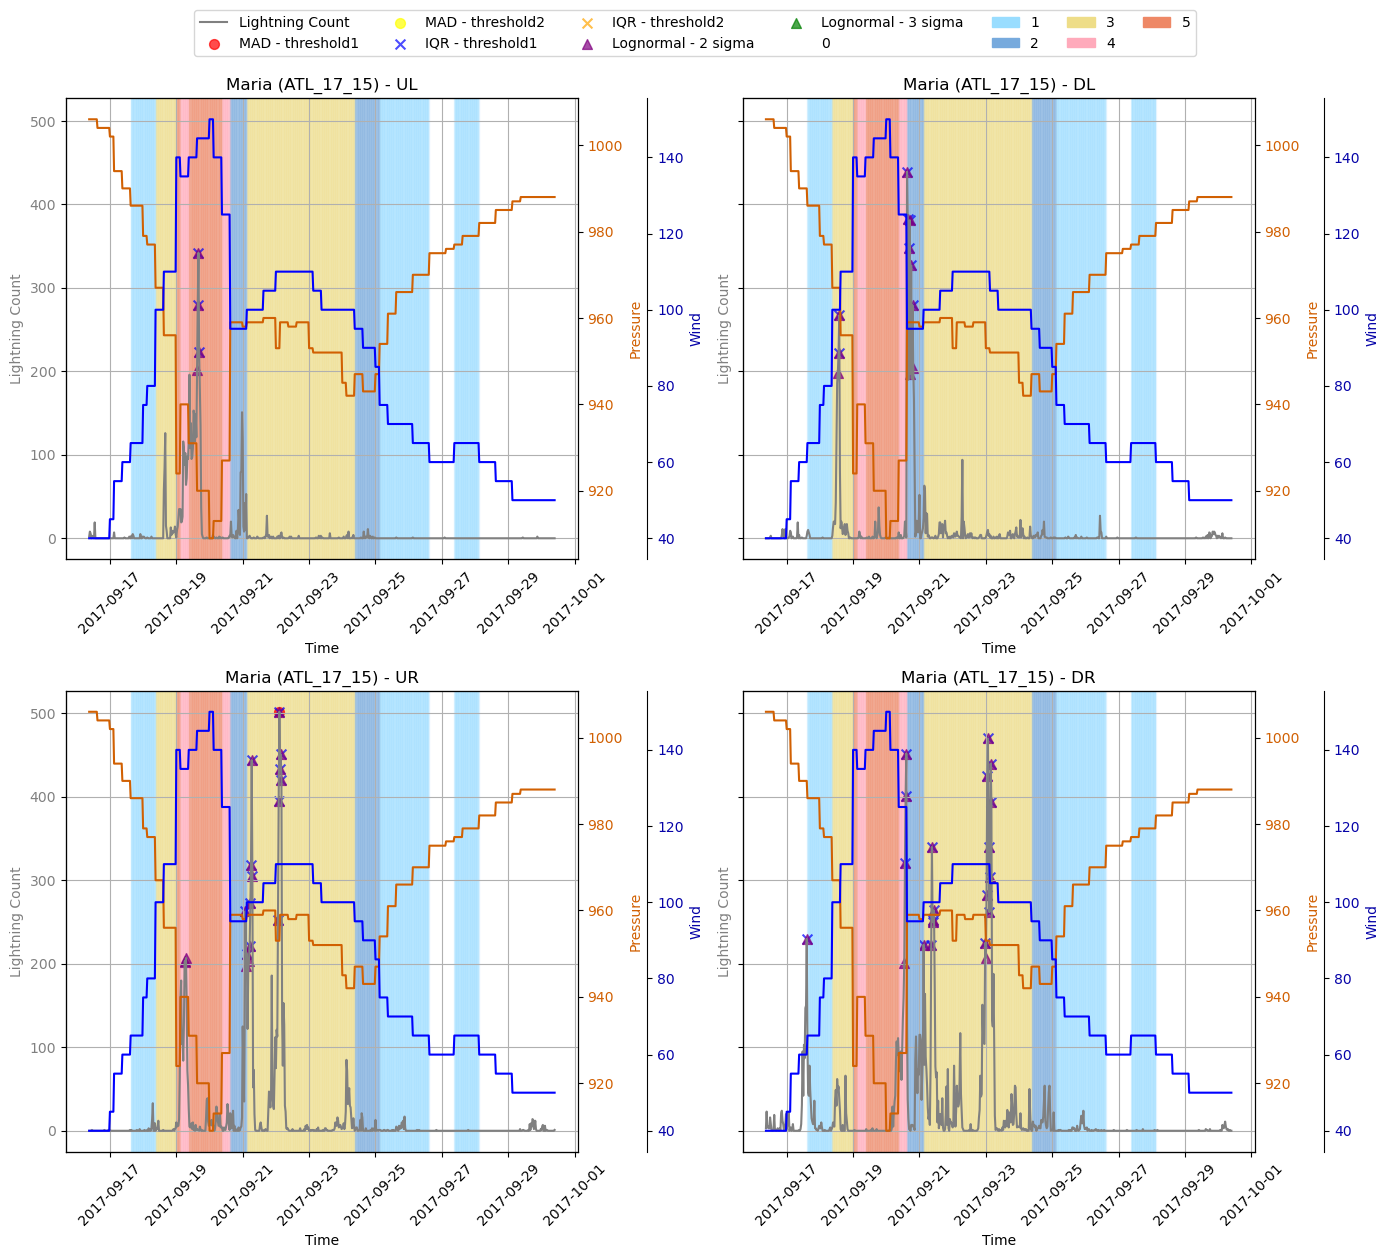

In [ ]:
# ATL_17_15 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

In [ ]:
# Export for external tool vis
rainband_data.write_csv("../vis_data/rainband_lightning_data.csv")
tc_summary.to_csv("../vis_data/rainband_threshold_summary.csv")
bursts.to_csv("../vis_data/rainband_bursts.csv")

In [21]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [22]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

1 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
22 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
